In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
print(sys.path)

['/home/hieutt/RD-OpenMax_CAN_IDS/notebooks', '/home/hieutt/miniconda3/envs/torchtf/lib/python39.zip', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/lib-dynload', '', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/site-packages', '../']


In [2]:
import os
import torch
import numpy as np
import pickle
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.manifold import TSNE
import seaborn as sns
from dataset import CANDataset5 as CANDataset
from rd_openmax import openmax_predict_rd
from rd_openmax_maha import openmax_predict_mahalanobis, extract_class_stats_mahalanobis, fit_weibull_mahalanobis
from model_init import *
from torchvision import transforms
from torch.utils.data import DataLoader


In [3]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
device = torch.device("cuda:1")

In [4]:
data_paths = {
    "close": "../data/set_04/test_01_known_vehicle_known_attack/preprocessed/six_features/TFRecord_w64_s32/2",
    "open_all": "../data/set_04/test_03_known_vehicle_unknown_attack/preprocessed/six_features/TFRecord_w64_s32/2",
    "open_dos": "../data/set_04/test_03_known_vehicle_unknown_attack/preprocessed/one_type/dos/TFRecord_w64_s32/2",
    "open_double": "../data/set_04/test_03_known_vehicle_unknown_attack/preprocessed/one_type/triple/TFRecord_w64_s32/2",
    "open_force_neutral": "../data/set_04/test_03_known_vehicle_unknown_attack/preprocessed/one_type/force-neutral/TFRecord_w64_s32/2",
    "open_fuzzing": "../data/set_04/test_03_known_vehicle_unknown_attack/preprocessed/one_type/fuzzing/TFRecord_w64_s32/2",
    "open_triple": "../data/set_04/test_03_known_vehicle_unknown_attack/preprocessed/one_type/triple/TFRecord_w64_s32/2"
}
n_classes = 6
batch_size = 256
window_size = 32


In [5]:
from util import AddGaussianNoise, SelectiveNormalize, SelectiveTransform, TwoCropTransform
from torchvision import transforms
train_dataset_folder = "../data/set_04/train_01/preprocessed/six_features/TFRecord_w64_s32/2"

normalize = transforms.Normalize(mean=(0.5, 0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5, 0.5))
test_transform = transforms.Compose([normalize])

train_transform = transforms.Compose([
    transforms.RandomApply([AddGaussianNoise(0., 0.05)], p=0.5),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15)),
    normalize
])
# # Khởi tạo dataset
train_dataset = CANDataset(root_dir=train_dataset_folder, window_size=32, is_train=True, transform=TwoCropTransform(train_transform))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True, drop_last=True)

In [6]:
def create_loader(path, batch_size=batch_size, is_train=False):
    dataset = CANDataset(root_dir=path, window_size=window_size, is_train=is_train, transform=test_transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataset, loader


In [7]:
datasets = {}
loaders = {}

for key, path in data_paths.items():
    datasets[key], loaders[key] = create_loader(path)

In [8]:
# Configuration
# /home/hieutt/RD-OpenMax_CAN_IDS/save/CAN_TT_models/UniCon/UniCon_CAN_TT_mpncovresnet50_lr_0.05_decay_0.0001_bsz_256_trial_F-DEF_4_Maha_v4_Freeze_cosine_warm
ckpt_path = "../save/CAN_TT_models/UniCon/UniCon_CAN_TT_mpncovresnet50_lr_0.05_decay_0.0001_bsz_256_trial_F-DEF_4_Maha_v4_Freeze_cosine_warm/ckpt_epoch_44.pth"
class_model_path = "../save/CAN_TT_models/UniCon/UniCon_CAN_TT_mpncovresnet50_lr_0.05_decay_0.0001_bsz_256_trial_F-DEF_4_Maha_v4_Freeze_cosine_warm/ckpt_classifier_epoch_44.pth"
weibull_path = ckpt_path.replace("ckpt_epoch_44.pth", "weibull_epoch_44.pkl")


In [9]:
def change_state_dict(state_dict):
    """
    Because state dict in distributed GPU is different
    """
    new_state_dict = {}
    for k, v in state_dict.items():
        k = k.replace("module.", "")
        new_state_dict[k] = v
    return new_state_dict

In [10]:
from networks.con_mpncovresnet_feat import ConTinyMPNCOVResNet, LinearClassifier

model = ConTinyMPNCOVResNet(
    attention='Cov',
    input_size=64,
    feat_dim=128
)
classifier = LinearClassifier(input_dim=8256, num_classes=n_classes)

model.to(device)
classifier.to(device)

ckpt = torch.load(ckpt_path, weights_only=False)
state_dict = ckpt['model']
state_dict = change_state_dict(state_dict)
model.load_state_dict(state_dict=state_dict)

ckpt = torch.load(class_model_path, weights_only=False)
state_dict = ckpt['model']
classifier.load_state_dict(state_dict=state_dict)
# _, _, class_inv_covs = extract_class_stats_mahalanobis(model, classifier, train_loader, device)
# 3. Load Weibull models
with open(weibull_path, 'rb') as f:
    weibull_data = pickle.load(f)
class_means = weibull_data['class_means']
weibull_models = weibull_data['weibull_models']
class_inv_covs = weibull_data['class_inv_covs']


In [11]:
def evaluate_open_set(model, classifier, open_loader, class_means, weibull_models, class_inv_covs, device, best_thresh=0.7212):
    total_preds = []
    total_feats = []
    total_labels = []
    unk_probs = []

    model.eval()
    if classifier is not None:
        classifier.eval()

    with torch.no_grad():
        for images, labels in open_loader:
            if isinstance(images, (list, tuple)):
                images = images[0]
            
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # 🧠 Feature embedding
            feats = model(images)
            feats = F.normalize(feats, dim=1)
            feats_np = feats.cpu().numpy()
            total_feats.append(feats_np)

            for f, label in zip(feats_np, labels.cpu().numpy()):
                pred_class, unk_prob = openmax_predict_mahalanobis(f, class_means, class_inv_covs, weibull_models)
                total_preds.append((pred_class, unk_prob))
                total_labels.append(label)
                unk_probs.append(unk_prob)

    total_feats_np = np.concatenate(total_feats, axis=0)

    # Mapping labels: 0 = known, else = unknown
    mapped_label = [0 if l == 0 else 1 for l in total_labels]
    mapped_pred = [0 if p[1] < best_thresh else 1 for p in total_preds]

    return {
        "mapped_label": mapped_label,
        "mapped_pred": mapped_pred,
        "unk_probs": unk_probs,
        "total_feats": total_feats_np,
        "raw_preds": total_preds,
        "labels": total_labels
    }


In [21]:
results = {}
for name in ['open_all', 'open_dos', 'open_double', 'open_force_neutral', 'open_fuzzing', 'open_triple']:
    print(f"🔍 Evaluating on: {name}")
    res = evaluate_open_set(
        model=model,
        classifier=classifier,
        open_loader=loaders[name],
        class_means=class_means,
        weibull_models=weibull_models,
        class_inv_covs=class_inv_covs,
        device=device,
        best_thresh=0.7744
    )
    results[name] = res

🔍 Evaluating on: open_all
🔍 Evaluating on: open_dos
🔍 Evaluating on: open_double
🔍 Evaluating on: open_force_neutral
🔍 Evaluating on: open_fuzzing
🔍 Evaluating on: open_triple


In [22]:
# 📊 Evaluation
def evaluate_and_print_metrics(results_dict):
    """
    results_dict: dictionary dạng {dataset_name: result_dict}
    Trong đó result_dict chứa:
        - mapped_label
        - mapped_pred
    """
    for name, res in results_dict.items():
        y_true = res['mapped_label']
        y_pred = res['mapped_pred']
        
        acc = accuracy_score(y_true, y_pred) * 100
        f1 = f1_score(y_true, y_pred, average='binary')
        precision = precision_score(y_true, y_pred, average='binary', zero_division=0)
        recall = recall_score(y_true, y_pred, average='binary')
        conf_matrix = confusion_matrix(y_true, y_pred)
        
        print(f"\n📁 Dataset: {name}")
        print(f"🔹 Accuracy: {acc:.2f}%")
        print(f"🔹 F1 Score: {f1:.4f}")
        print(f"🔹 Precision: {precision:.4f}")
        print(f"🔹 Recall: {recall:.4f}")
        print("🔹 Confusion Matrix:")
        print(conf_matrix)

In [23]:
# 📊 Result
evaluate_and_print_metrics(results)


📁 Dataset: open_all
🔹 Accuracy: 95.27%
🔹 F1 Score: 0.7847
🔹 Precision: 0.8951
🔹 Recall: 0.6985
🔹 Confusion Matrix:
[[9277  108]
 [ 398  922]]

📁 Dataset: open_dos
🔹 Accuracy: 87.37%
🔹 F1 Score: 0.0632
🔹 Precision: 0.1452
🔹 Recall: 0.0404
🔹 Confusion Matrix:
[[1838   53]
 [ 214    9]]

📁 Dataset: open_double
🔹 Accuracy: 99.79%
🔹 F1 Score: 0.9966
🔹 Precision: 0.9932
🔹 Recall: 1.0000
🔹 Confusion Matrix:
[[1363    4]
 [   0  583]]

📁 Dataset: open_force_neutral
🔹 Accuracy: 91.51%
🔹 F1 Score: 0.0000
🔹 Precision: 0.0000
🔹 Recall: 0.0000
🔹 Confusion Matrix:
[[1434    0]
 [ 133    0]]

📁 Dataset: open_fuzzing
🔹 Accuracy: 96.18%
🔹 F1 Score: 0.7969
🔹 Precision: 0.8407
🔹 Recall: 0.7574
🔹 Confusion Matrix:
[[1813   29]
 [  49  153]]

📁 Dataset: open_triple
🔹 Accuracy: 99.79%
🔹 F1 Score: 0.9966
🔹 Precision: 0.9932
🔹 Recall: 1.0000
🔹 Confusion Matrix:
[[1363    4]
 [   0  583]]


In [25]:
import pandas as pd

def plot_all_metrics(result, dataset_name=""):
    unk_probs = result['unk_probs']
    targets = result['mapped_label']
    preds = result['mapped_pred']

    threshold = 0.7744  # Best threshold found
    fpr, tpr, _ = roc_curve(targets, unk_probs)
    auc = roc_auc_score(targets, unk_probs)
    cm = confusion_matrix(targets, preds)

    df = pd.DataFrame({
        'Unknown Probability': unk_probs,
        'Class': ['Unknown' if t == 1 else 'Known' for t in targets]
    })

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # 1️⃣ Violin plot
    sns.violinplot(x='Class', y='Unknown Probability', hue='Class',
                   data=df, palette='Set2', ax=axs[0], legend=False)
    axs[0].set_title('Unknown Probabilities')
    
    # 🔽 Add horizontal threshold line
    axs[0].axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.2f}')
    axs[0].legend()

    # 2️⃣ Confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Known', 'Unknown'],
                yticklabels=['Known', 'Unknown'], ax=axs[1])
    axs[1].set_title('Confusion Matrix')
    axs[1].set_xlabel('Predicted')
    axs[1].set_ylabel('Actual')

    # 3️⃣ ROC curve
    axs[2].plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    axs[2].plot([0, 1], [0, 1], '--', color='gray')
    axs[2].set_title('ROC Curve')
    axs[2].set_xlabel('False Positive Rate')
    axs[2].set_ylabel('True Positive Rate')
    axs[2].legend()
    axs[2].grid(True)


    fig.suptitle(f"Visualization for {dataset_name}", fontsize=16)
    plt.tight_layout()
    plt.show()


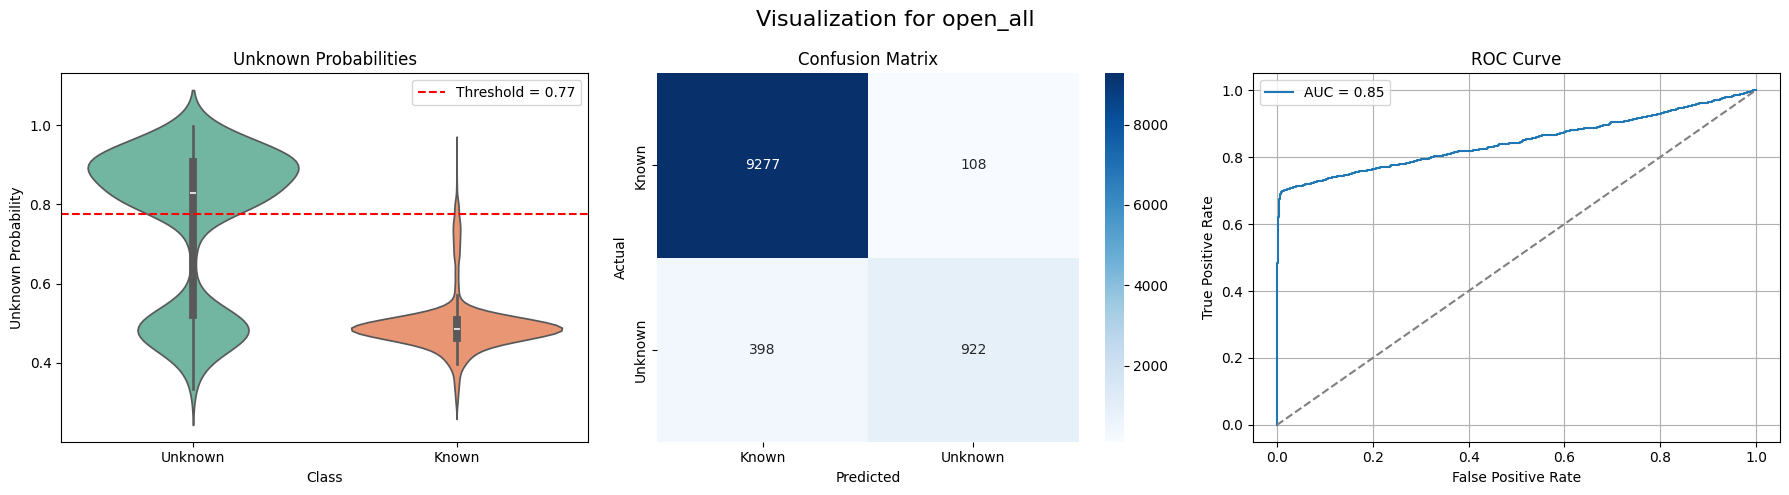

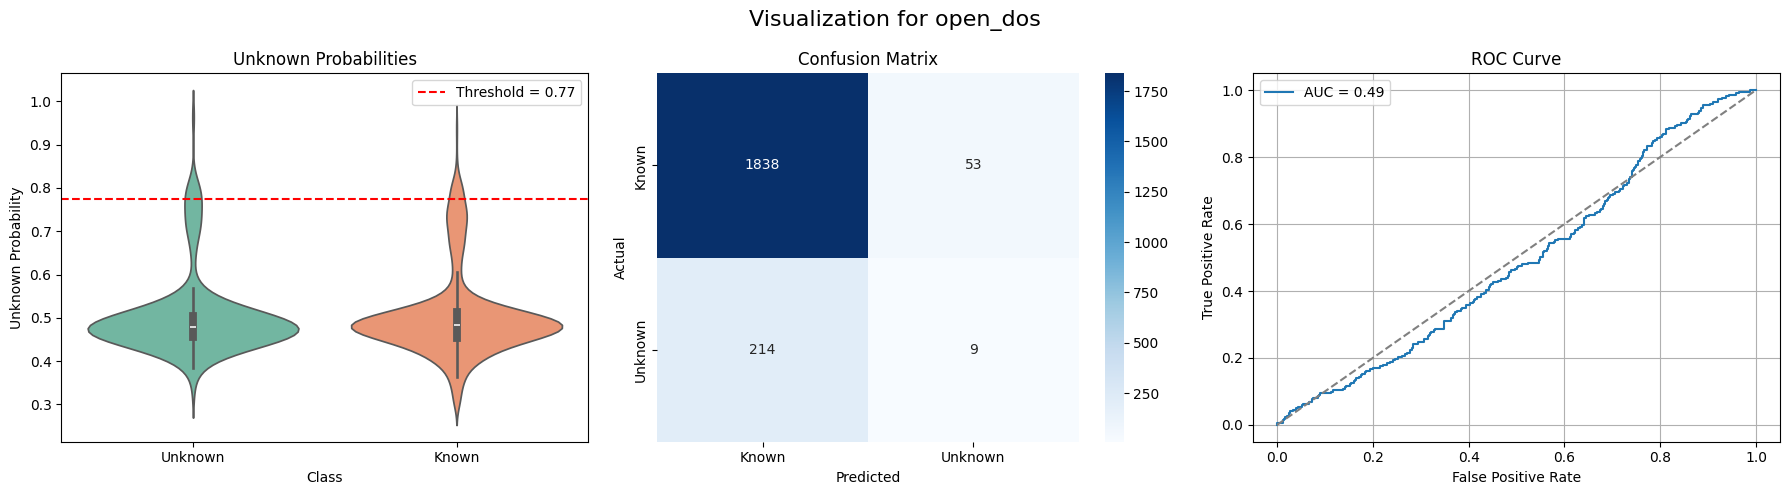

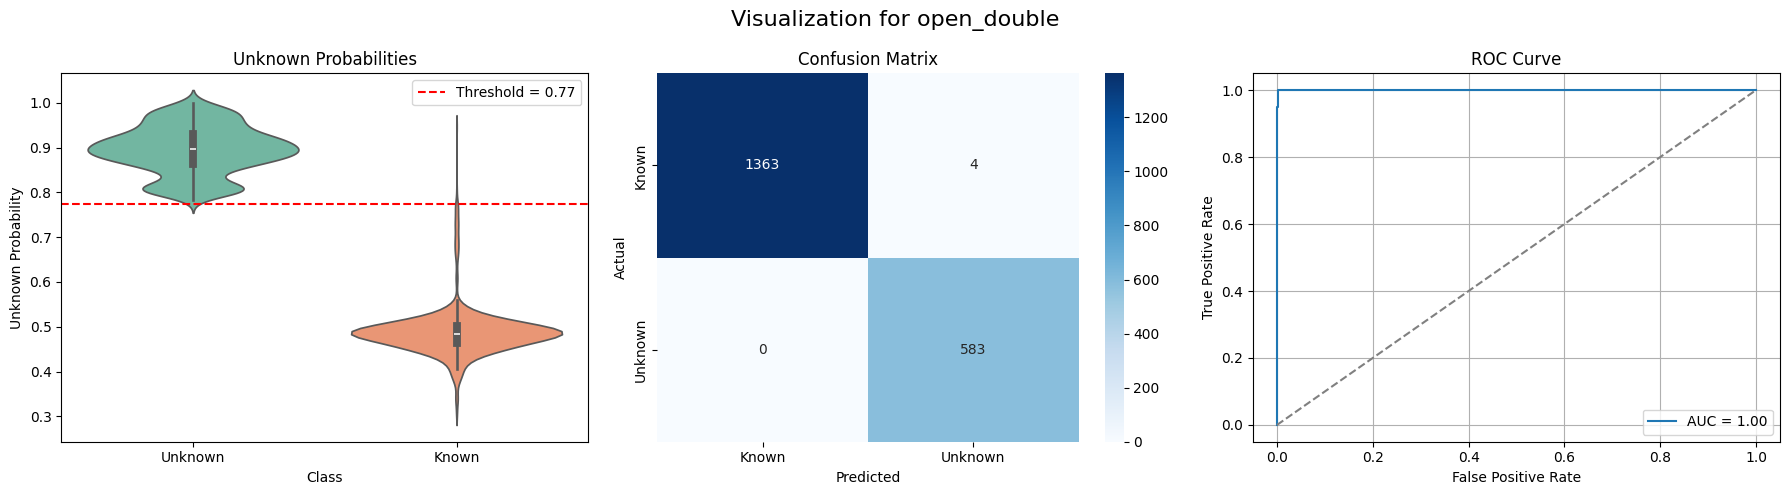

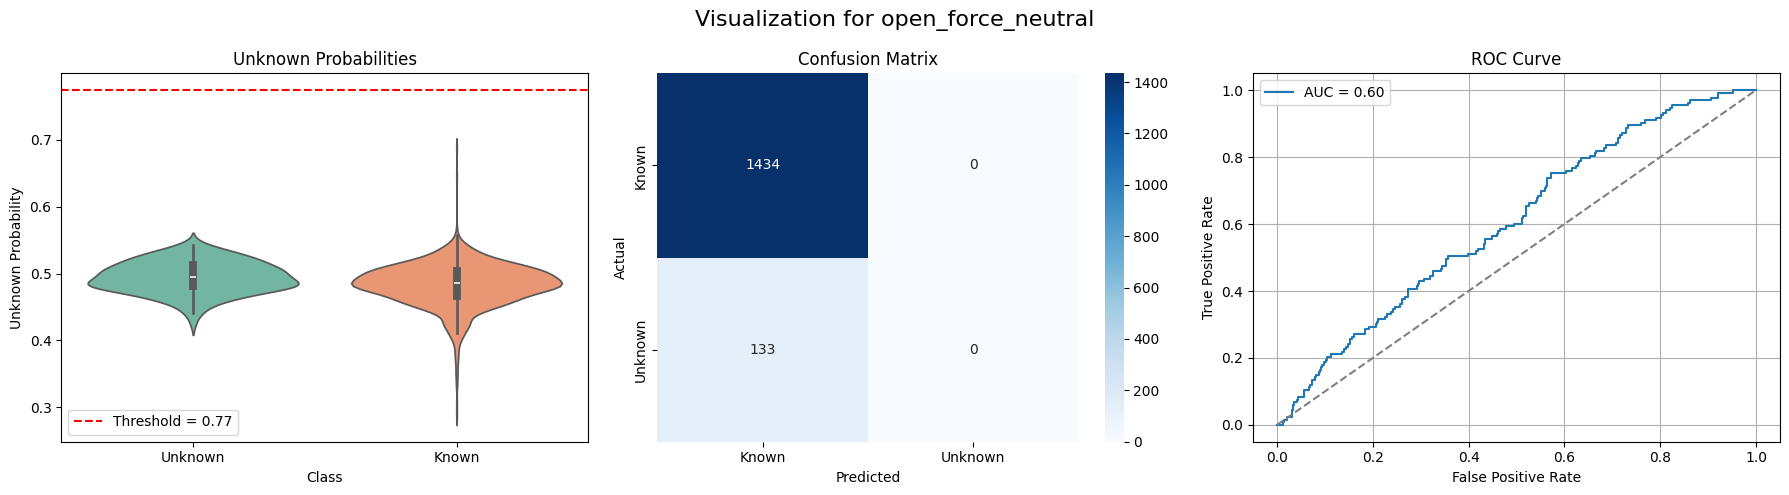

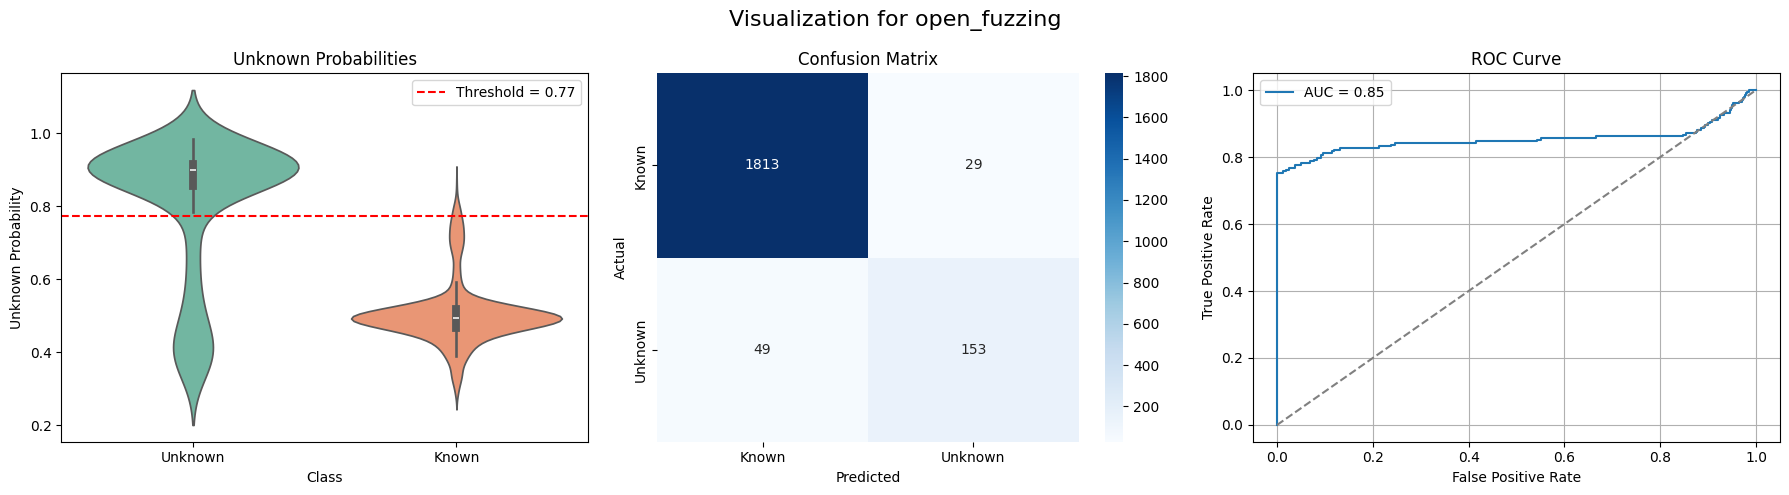

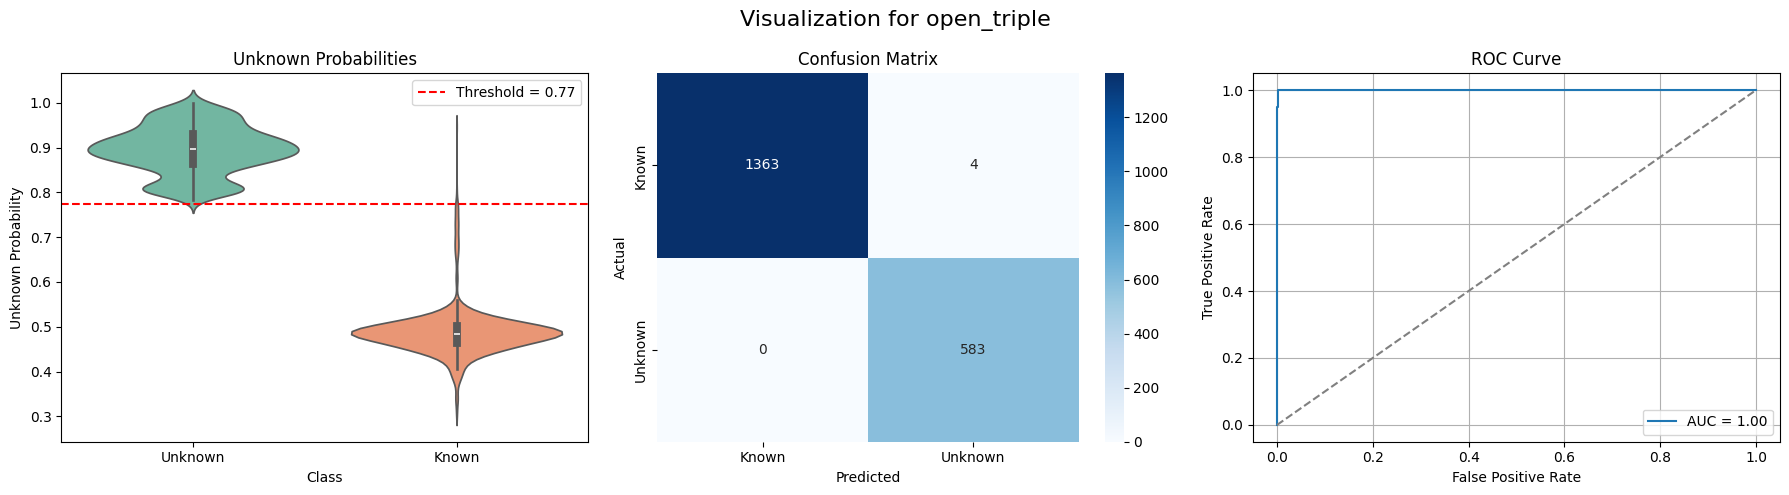

In [26]:
for name, res in results.items():
    plot_all_metrics(res, dataset_name=name)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

def plot_2_metrics(result, dataset_name=""):
    unk_probs = result['unk_probs']
    targets = result['mapped_label']
    
    # Chỉ dùng ROC, không cần mapped_pred nữa
    fpr, tpr, _ = roc_curve(targets, unk_probs)
    auc = roc_auc_score(targets, unk_probs)

    # DataFrame cho Violin plot
    df = pd.DataFrame({
        'Unknown Probability': unk_probs,
        'Class': ['Unknown' if t == 1 else 'Known' for t in targets]
    })

    # Tạo 2 subplot thay vì 3
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # 1️⃣ Violin plot
    sns.violinplot(x='Class', y='Unknown Probability', hue='Class',
                   data=df, palette='Set2', ax=axs[0], legend=False)
    axs[0].set_title('Unknown Probabilities')

    # 2️⃣ ROC curve
    axs[1].plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    axs[1].plot([0, 1], [0, 1], '--', color='gray')
    axs[1].set_title('ROC Curve')
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')
    axs[1].legend()
    axs[1].grid(True)

    # Tổng tiêu đề
    fig.suptitle(f"Visualization for {dataset_name}", fontsize=16)
    plt.tight_layout()
    plt.show()


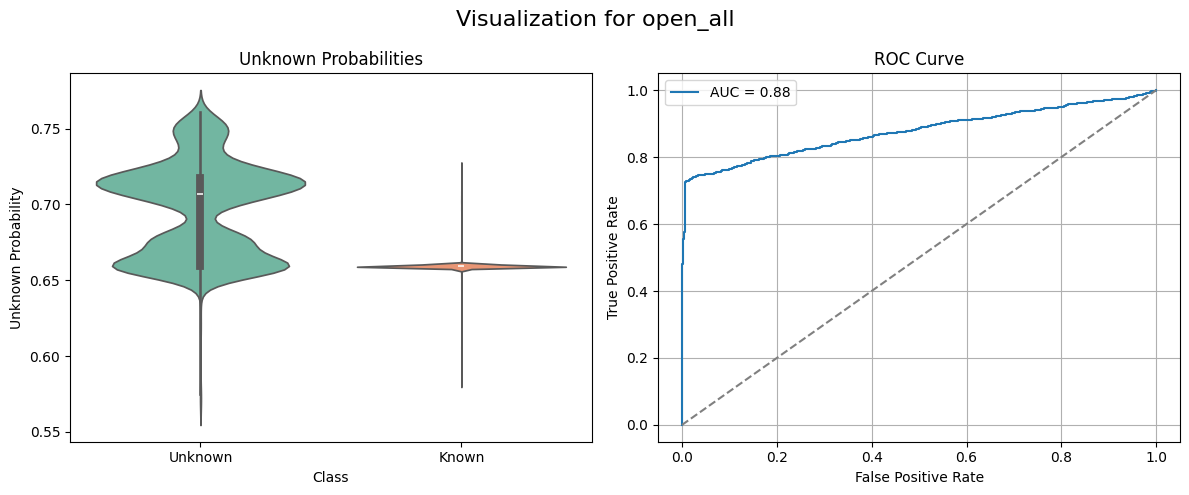

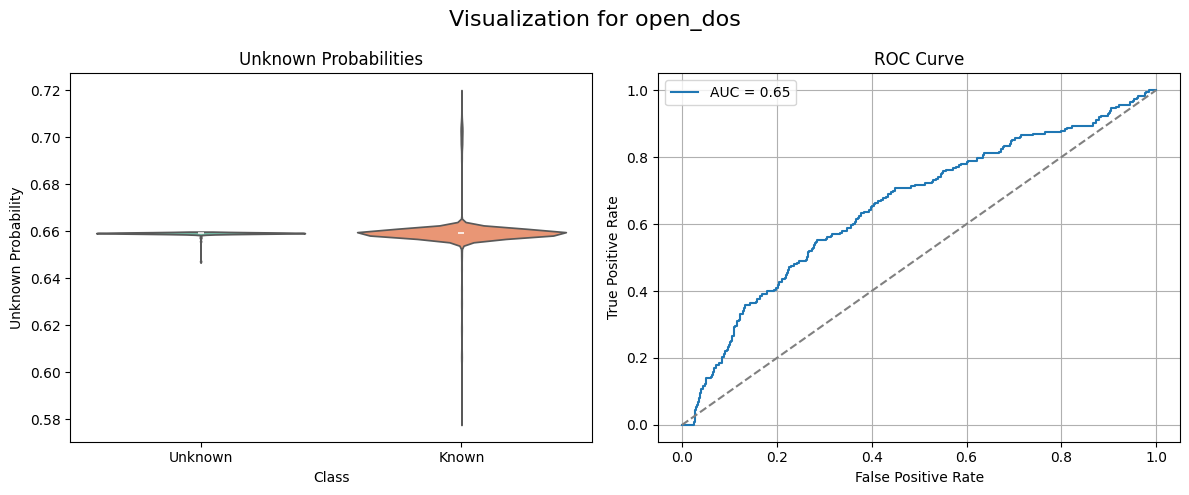

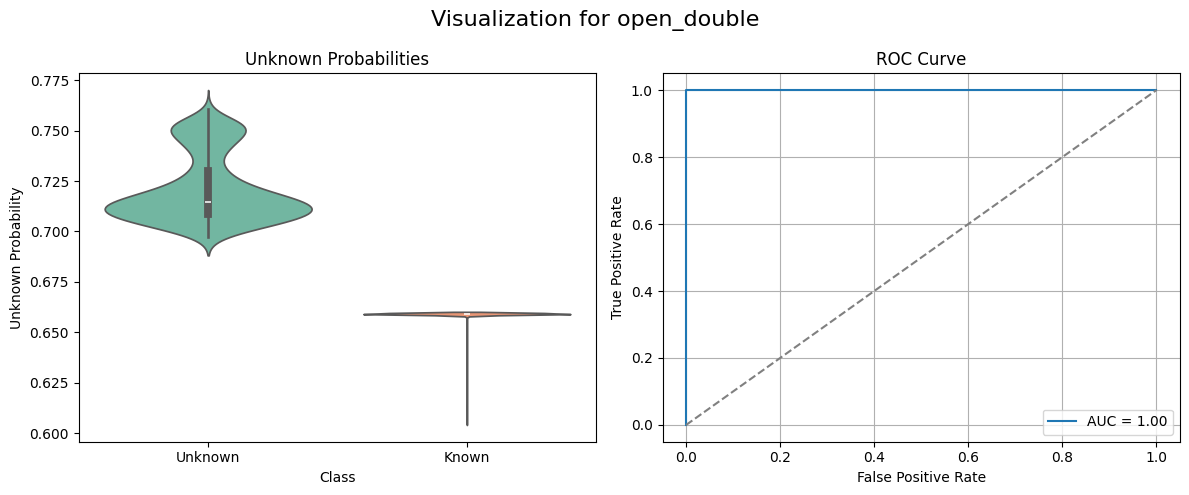

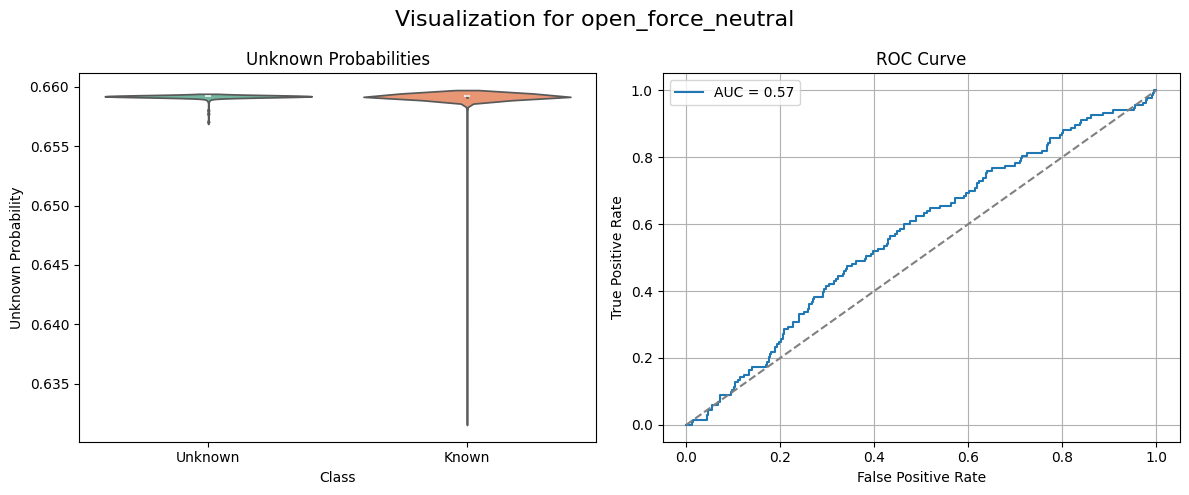

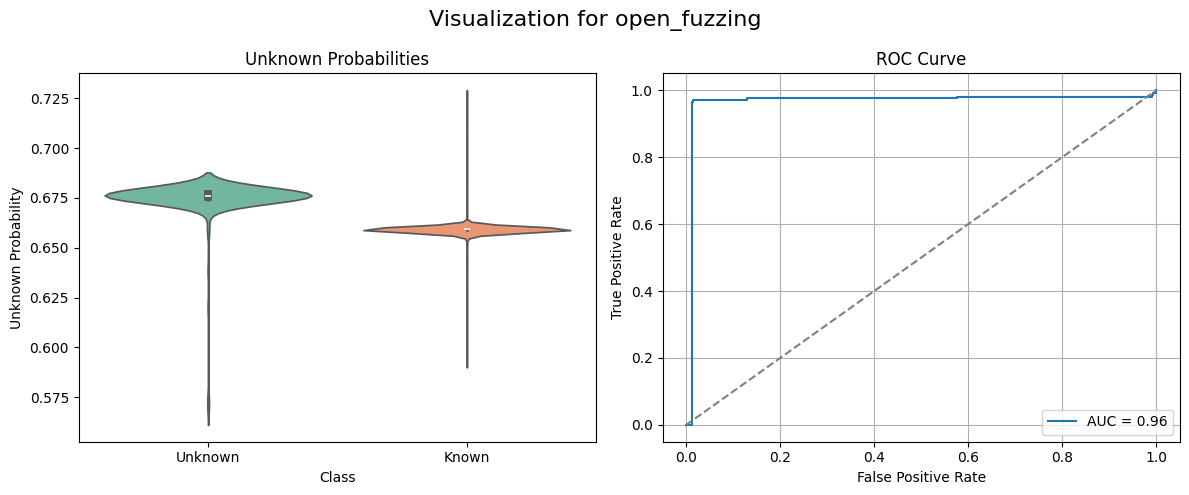

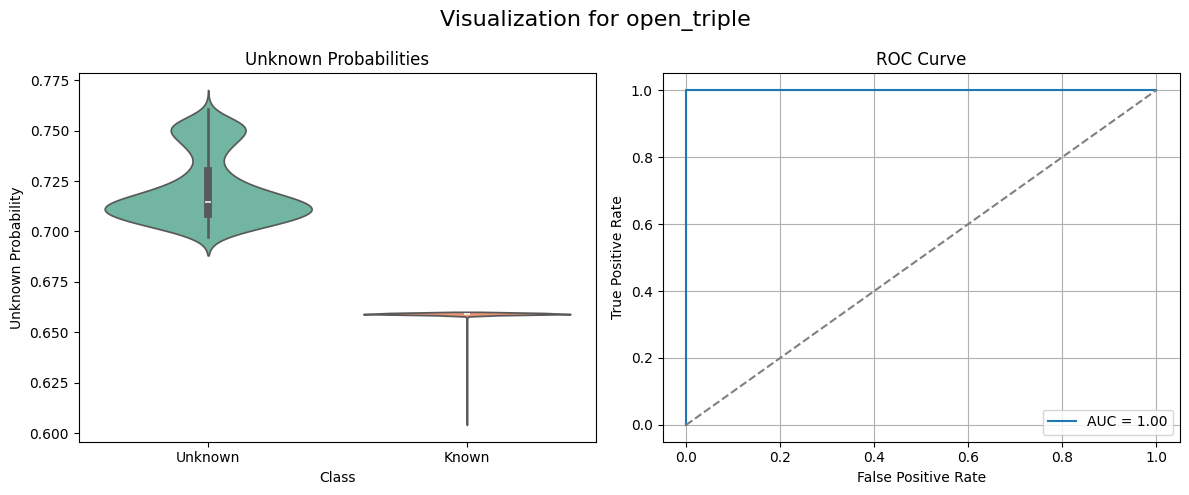

In [31]:
for name, res in results.items():
    plot_2_metrics(res, dataset_name=name)

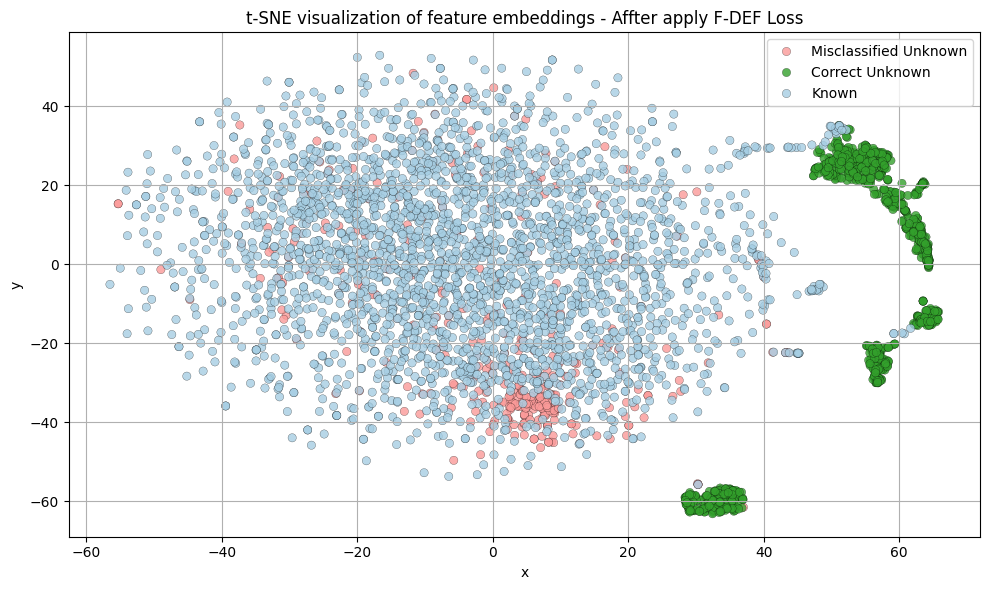

In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Chọn output của "open_dos"
res = results['open_all']

X = res["total_feats"]
y_true = res["mapped_label"]
y_pred = res["mapped_pred"]
unk_probs = res["unk_probs"]

# Giảm chiều bằng t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_2d = tsne.fit_transform(X)

# Tạo DataFrame
df_vis = pd.DataFrame({
    "x": X_2d[:, 0],
    "y": X_2d[:, 1],
    "TrueLabel": y_true,
    "PredLabel": y_pred,
    "UnkProb": unk_probs
})

# Phân loại theo trạng thái
def status(row):
    if row["TrueLabel"] == 1 and row["PredLabel"] == 0:
        return "Misclassified Unknown"
    elif row["TrueLabel"] == 1:
        return "Correct Unknown"
    else:
        return "Known"
df_vis["Status"] = df_vis.apply(status, axis=1)

# Tách các nhóm
df_mis = df_vis[df_vis["Status"] == "Misclassified Unknown"]
df_correct = df_vis[df_vis["Status"] == "Correct Unknown"]
df_known = df_vis[df_vis["Status"] == "Known"]

# Chỉ lấy một phần Known (undersample để không bị rối)
n_known_to_sample = min(len(df_known), len(df_mis) + len(df_correct)) * 2
df_known_sampled = df_known.sample(n=n_known_to_sample, random_state=42)

# Kết hợp lại
df_plot = pd.concat([df_mis, df_correct, df_known_sampled], ignore_index=True)

# Tùy chỉnh kích thước điểm
size_map = {
    "Misclassified Unknown": 80,
    "Correct Unknown": 60,
    "Known": 30
}
df_plot["Size"] = df_plot["Status"].map(size_map)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_plot,
    x='x', y='y',
    hue='Status',
    palette={"Known": "#A6CEE3", "Correct Unknown": "#33A02C", "Misclassified Unknown": "#FB9A99"},
    sizes=(30, 80),
    alpha=0.8,
    edgecolor="black",
    linewidth=0.2
)
plt.title('t-SNE visualization of feature embeddings - Affter apply F-DEF Loss')
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


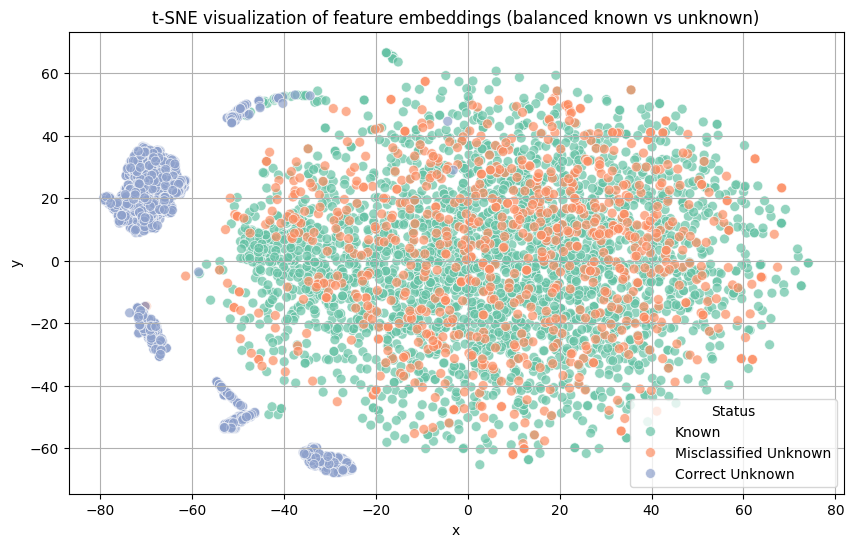

In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Chọn output của "open_all"
res = results['open_all']

X = res["total_feats"]
y_true = res["mapped_label"]
y_pred = res["mapped_pred"]
unk_probs = res["unk_probs"]

# Giảm chiều bằng t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_2d = tsne.fit_transform(X)

# Tạo DataFrame gốc
df_vis = pd.DataFrame({
    "x": X_2d[:, 0],
    "y": X_2d[:, 1],
    "TrueLabel": y_true,
    "PredLabel": y_pred,
    "UnkProb": unk_probs
})

# Phân loại status
def status(row):
    if row["TrueLabel"] == 1 and row["PredLabel"] == 0:
        return "Misclassified Unknown"
    elif row["TrueLabel"] == 1:
        return "Correct Unknown"
    else:
        return "Known"

df_vis["Status"] = df_vis.apply(status, axis=1)

# Lấy số lượng unknown
n_unknown = df_vis[df_vis["Status"] != "Known"].shape[0]

# Lấy ngẫu nhiên n_unknown mẫu từ nhóm Known
df_known = df_vis[df_vis["Status"] == "Known"].sample(n=n_unknown, random_state=42)
df_unknown = df_vis[df_vis["Status"] != "Known"]

# Kết hợp lại
df_balanced = pd.concat([df_known, df_unknown], ignore_index=True)

# Vẽ scatter
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_balanced, x='x', y='y', hue='Status', palette="Set2", s=50, alpha=0.7)
plt.title('t-SNE visualization of feature embeddings (balanced known vs unknown)')
plt.grid(True)
plt.show()


In [25]:
from scipy.spatial.distance import cosine

sample_idx = 10  # ví dụ 1 sample bị nhầm
feat = res["total_feats"][sample_idx]
true_lbl = res["labels"][sample_idx]
pred_lbl = res["raw_preds"][sample_idx][0]
unk_prob = res["unk_probs"][sample_idx]

print(f"🔎 True Label: {true_lbl}, Predicted: {pred_lbl}, Unknown Prob: {unk_prob:.4f}")

# So sánh khoảng cách đến các class_means
distances = {
    cls: cosine(feat, mean) for cls, mean in class_means.items()
}
sorted_distances = sorted(distances.items(), key=lambda x: x[1])
print("📐 Top 3 closest class means:")
for cls, dist in sorted_distances[:3]:
    print(f"Class {cls}: Distance = {dist:.4f}")


🔎 True Label: 1, Predicted: 0, Unknown Prob: 0.7039
📐 Top 3 closest class means:
Class 0: Distance = 0.0942
Class 2: Distance = 0.9874
Class 3: Distance = 0.9938
